# ***Feature Engineering***

# 📚 ***Import libraries***

In [1]:
# base libraries for data science
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from dython.nominal import associations

# 💾 ***Load data***

In [2]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"

nyc_houses_df = pd.read_parquet(
    DATA_DIR / "02_intermediate/nyc_houses_fixed.parquet", engine="pyarrow"
)

In [3]:
# print library version for reproducibility

print("Pandas version: ", pd.__version__)
print("sklearn version: ", sk.__version__)

Pandas version:  2.2.3
sklearn version:  1.6.1


# 👷 ***Data preparation***

In [4]:
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137276 entries, 0 to 137275
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   BUILDING CLASS AT PRESENT       136043 non-null  category      
 1   COMMERCIAL UNITS                137274 non-null  Int64         
 2   BUILDING CLASS CATEGORY         137274 non-null  category      
 3   BUILDING CLASS AT TIME OF SALE  137274 non-null  category      
 4   LOT                             137274 non-null  float64       
 5   TOTAL UNITS                     137274 non-null  Int64         
 6   TAX CLASS AT TIME OF SALE       137274 non-null  float64       
 7   ADDRESS                         137274 non-null  category      
 8   TAX CLASS AT PRESENT            136043 non-null  category      
 9   ZIP CODE                        137274 non-null  float64       
 10  SALE DATE                       137274 non-null  datetim

In [5]:
cols_cat = ['BLOCK', 'LOT', 'ZIP CODE', 'BOROUGH', 'TAX CLASS AT TIME OF SALE']
nyc_houses_df[cols_cat] = nyc_houses_df[cols_cat].astype('category')

In [6]:
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137276 entries, 0 to 137275
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   BUILDING CLASS AT PRESENT       136043 non-null  category      
 1   COMMERCIAL UNITS                137274 non-null  Int64         
 2   BUILDING CLASS CATEGORY         137274 non-null  category      
 3   BUILDING CLASS AT TIME OF SALE  137274 non-null  category      
 4   LOT                             137274 non-null  category      
 5   TOTAL UNITS                     137274 non-null  Int64         
 6   TAX CLASS AT TIME OF SALE       137274 non-null  category      
 7   ADDRESS                         137274 non-null  category      
 8   TAX CLASS AT PRESENT            136043 non-null  category      
 9   ZIP CODE                        137274 non-null  category      
 10  SALE DATE                       137274 non-null  datetim

***Elimination of duplicates***

This is done to prioritize that the duplicates to be deleted are not values where SALE PRICE has a value.

In [7]:
# Count duplicates before removal
initial_duplicates = nyc_houses_df.duplicated().sum()

# Sort so that non-null 'SALE PRICE' values come first
nyc_houses_df = nyc_houses_df.sort_values(by='SALE PRICE', ascending=False, na_position='last')

# Remove duplicates across all columns, keeping the first occurrence
nyc_houses_df = nyc_houses_df.drop_duplicates(keep='first')

# Count duplicates after cleaning
remaining_duplicates = nyc_houses_df.duplicated().sum()

# Print summary of duplicates removed
print(f"Duplicates removed: {initial_duplicates}")
print(f"Duplicates remaining after cleaning: {remaining_duplicates}")


Duplicates removed: 70126
Duplicates remaining after cleaning: 0


In [8]:
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67150 entries, 49566 to 67633
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BUILDING CLASS AT PRESENT       66543 non-null  category      
 1   COMMERCIAL UNITS                67149 non-null  Int64         
 2   BUILDING CLASS CATEGORY         67149 non-null  category      
 3   BUILDING CLASS AT TIME OF SALE  67149 non-null  category      
 4   LOT                             67149 non-null  category      
 5   TOTAL UNITS                     67149 non-null  Int64         
 6   TAX CLASS AT TIME OF SALE       67149 non-null  category      
 7   ADDRESS                         67149 non-null  category      
 8   TAX CLASS AT PRESENT            66543 non-null  category      
 9   ZIP CODE                        67149 non-null  category      
 10  SALE DATE                       67149 non-null  datetime64[ns]
 11  NEI

***For visualization purposes, we are going to see again how many nulls (and zero values) each column has***

In [9]:
def missing_and_zero_values_summary(df):
    """
    Generate a summary of missing and zero values in a DataFrame, including numerical and string '0' values.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        pd.DataFrame: A summary DataFrame showing the count and percentage of null and zero values per column.
    """
    nulos_count = df.isnull().sum()
    nulos_percentage = (nulos_count / len(df)) * 100

    zero_values_count_numeric = df.eq(0).sum()

    zero_values_count_text = df.apply(lambda col: (col.astype(str) == '0').sum() if col.dtypes == 'object' else 0)

    zero_values_count = zero_values_count_numeric + zero_values_count_text
    zero_values_percentage = (zero_values_count / len(df)) * 100

    summary_df = pd.DataFrame({
        'Nulls': nulos_count,
        'Percentage Nulls (%)': nulos_percentage,
        'Zero values': zero_values_count,
        'Percentage Zeros (%)': zero_values_percentage
    }).sort_values(by='Percentage Nulls (%)', ascending=False)

    return summary_df

In [10]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
APARTMENT NUMBER,51991,77.425168,0,0.0
GROSS SQUARE FEET,21968,32.714818,9134,13.602383
LAND SQUARE FEET,20868,31.076694,8276,12.324646
SALE PRICE,11425,17.014147,8009,11.927029
TAX CLASS AT PRESENT,607,0.903946,0,0.0
BUILDING CLASS AT PRESENT,607,0.903946,0,0.0
COMMERCIAL UNITS,1,0.001489,63166,94.067014
BUILDING CLASS CATEGORY,1,0.001489,0,0.0
BUILDING CLASS AT TIME OF SALE,1,0.001489,0,0.0
LOT,1,0.001489,0,0.0


In [11]:
# Remove rows where 'GROSS SQUARE FEET' or 'LAND SQUARE FEET' are null
nyc_houses_df = nyc_houses_df.dropna(subset=['GROSS SQUARE FEET', 'LAND SQUARE FEET'])

# Verify rows were removed
print(f"New dataset shape: {nyc_houses_df.shape}")

New dataset shape: (45177, 20)


According to the glossary of variables, there are some that it makes ***NO SENSE*** to have a zero as data, therefore these will be converted to null, for a possible imputation of data.

However, this process will only be applied to columns that, by definition, do not make sense to have a value of zero (0).

This is done in this order to avoid deleting a lot of data initially because of these columns, in order to then make an imputation by the mean.

In [12]:
# Columns to nullify (replace 0 by NaN)
columns_to_nullify = [
    "GROSS SQUARE FEET",
    "LAND SQUARE FEET",
    "YEAR BUILT"
]

nyc_houses_df[columns_to_nullify] = nyc_houses_df[columns_to_nullify].replace(0, np.nan)

In [13]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
APARTMENT NUMBER,39770,88.031520,0,0.0
GROSS SQUARE FEET,9134,20.218253,0,0.0
LAND SQUARE FEET,8276,18.319056,0,0.0
SALE PRICE,6826,15.109458,8009,17.728047
YEAR BUILT,2305,5.102154,0,0.0
TAX CLASS AT PRESENT,292,0.646347,0,0.0
BUILDING CLASS AT PRESENT,292,0.646347,0,0.0
COMMERCIAL UNITS,0,0.000000,41266,91.34294
BUILDING CLASS AT TIME OF SALE,0,0.000000,0,0.0
BUILDING CLASS CATEGORY,0,0.000000,0,0.0


The ***ADDRESS & APARTMENT NUMBER & ZIP CODE*** columns will be droped because aren't relevant for the model. In addition ***`APARTMENT NUMBER`*** has almost 90% of the data as null.

In [14]:
nyc_houses_df = nyc_houses_df.drop(columns=['ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE'])

In [15]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
GROSS SQUARE FEET,9134,20.218253,0,0.0
LAND SQUARE FEET,8276,18.319056,0,0.0
SALE PRICE,6826,15.109458,8009,17.728047
YEAR BUILT,2305,5.102154,0,0.0
BUILDING CLASS AT PRESENT,292,0.646347,0,0.0
TAX CLASS AT PRESENT,292,0.646347,0,0.0
COMMERCIAL UNITS,0,0.000000,41266,91.34294
BUILDING CLASS AT TIME OF SALE,0,0.000000,0,0.0
BUILDING CLASS CATEGORY,0,0.000000,0,0.0
SALE DATE,0,0.000000,0,0.0


The null values of ***SALE PRICE*** will be eliminated, since it makes no sense to make up values and then make a prediction based on that. In addition, it is the target variable

In [16]:
nyc_houses_df = nyc_houses_df.dropna(subset=['SALE PRICE'])
print(f"New dataset shape: {nyc_houses_df.shape}")

New dataset shape: (38351, 17)


In [17]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
GROSS SQUARE FEET,9134,23.816850,0,0.0
LAND SQUARE FEET,8276,21.579620,0,0.0
YEAR BUILT,2302,6.002451,0,0.0
BUILDING CLASS AT PRESENT,292,0.761388,0,0.0
TAX CLASS AT PRESENT,292,0.761388,0,0.0
LOT,0,0.000000,0,0.0
COMMERCIAL UNITS,0,0.000000,35218,91.830721
BUILDING CLASS AT TIME OF SALE,0,0.000000,0,0.0
BUILDING CLASS CATEGORY,0,0.000000,0,0.0
SALE DATE,0,0.000000,0,0.0


By definition TOTAL UNITS is the sum of COMMERCIAL UNITS and RESIDENTIAL UNITS, so check that this is correct. If not, proceed with the correction.

In [18]:
# Check if TOTAL UNITS matches the sum of COMMERCIAL UNITS and RESIDENTIAL UNITS
matches = nyc_houses_df['TOTAL UNITS'].equals(nyc_houses_df['COMMERCIAL UNITS'] + nyc_houses_df['RESIDENTIAL UNITS'])

# Print result
if matches:
    print("✅ TOTAL UNITS is correctly calculated for all rows.")
else:
    print("❌ There are mismatches in TOTAL UNITS.")

# Count mismatches
mismatches = (nyc_houses_df['TOTAL UNITS'] != (nyc_houses_df['COMMERCIAL UNITS'] + nyc_houses_df['RESIDENTIAL UNITS'])).sum()
print(f"Total mismatched rows: {mismatches}")

❌ There are mismatches in TOTAL UNITS.
Total mismatched rows: 768


In [19]:
# Fix 'TOTAL UNITS' by assigning the correct sum
nyc_houses_df.loc[:, 'TOTAL UNITS'] = nyc_houses_df['COMMERCIAL UNITS'] + nyc_houses_df['RESIDENTIAL UNITS']

# Verify that all mismatches are gone
mismatches_after = (nyc_houses_df['TOTAL UNITS'] != (nyc_houses_df['COMMERCIAL UNITS'] + nyc_houses_df['RESIDENTIAL UNITS'])).sum()
print(f"✅ Total mismatched rows after correction: {mismatches_after}")

✅ Total mismatched rows after correction: 0


In [20]:
# Remove the existing 'TOTAL UNITS' column
nyc_houses_df = nyc_houses_df.drop(columns=['TOTAL UNITS'], errors='ignore')

# Recalculate 'TOTAL UNITS' as the sum of 'COMMERCIAL UNITS' and 'RESIDENTIAL UNITS'
nyc_houses_df['TOTAL UNITS'] = nyc_houses_df['COMMERCIAL UNITS'] + nyc_houses_df['RESIDENTIAL UNITS']

# Verify the new column
nyc_houses_df[['COMMERCIAL UNITS', 'RESIDENTIAL UNITS', 'TOTAL UNITS']].sample(5)


,COMMERCIAL UNITS,RESIDENTIAL UNITS,TOTAL UNITS
44607,0,11,11
17500,0,3,3
109405,0,1,1
5281,1,2,3
103649,0,1,1


In [21]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
GROSS SQUARE FEET,9134,23.816850,0,0.0
LAND SQUARE FEET,8276,21.579620,0,0.0
YEAR BUILT,2302,6.002451,0,0.0
BUILDING CLASS AT PRESENT,292,0.761388,0,0.0
TAX CLASS AT PRESENT,292,0.761388,0,0.0
LOT,0,0.000000,0,0.0
COMMERCIAL UNITS,0,0.000000,35218,91.830721
BUILDING CLASS AT TIME OF SALE,0,0.000000,0,0.0
BUILDING CLASS CATEGORY,0,0.000000,0,0.0
NEIGHBORHOOD,0,0.000000,0,0.0


In [22]:
nyc_houses_df.describe()

,COMMERCIAL UNITS,SALE DATE,RESIDENTIAL UNITS,GROSS SQUARE FEET,SALE PRICE,YEAR BUILT,LAND SQUARE FEET,TOTAL UNITS
count,38351.0,38351,38351.0,2.921700e+04,3.835100e+04,36049.0,3.007500e+04,38351.0
mean,0.246304,2017-02-25 05:50:01.298531840,2.446455,4.461029e+03,1.168289e+06,1945.223806,4.112533e+03,2.692759
min,0.0,2016-09-01 00:00:00,0.0,6.000000e+01,0.000000e+00,1800.0,2.000000e+00,0.0
25%,0.0,2016-11-29 00:00:00,1.0,1.428000e+03,1.000000e+05,1920.0,2.000000e+03,1.0
50%,0.0,2017-02-24 00:00:00,1.0,2.000000e+03,4.850000e+05,1931.0,2.500000e+03,1.0
75%,0.0,2017-05-25 00:00:00,2.0,2.880000e+03,8.350000e+05,1964.0,3.800000e+03,2.0
max,2261.0,2017-08-31 00:00:00,894.0,1.617206e+06,2.210000e+09,2017.0,3.014056e+06,2261.0
std,12.033486,NaN,13.831879,2.615392e+04,1.470304e+07,34.372523,2.914974e+04,18.391595


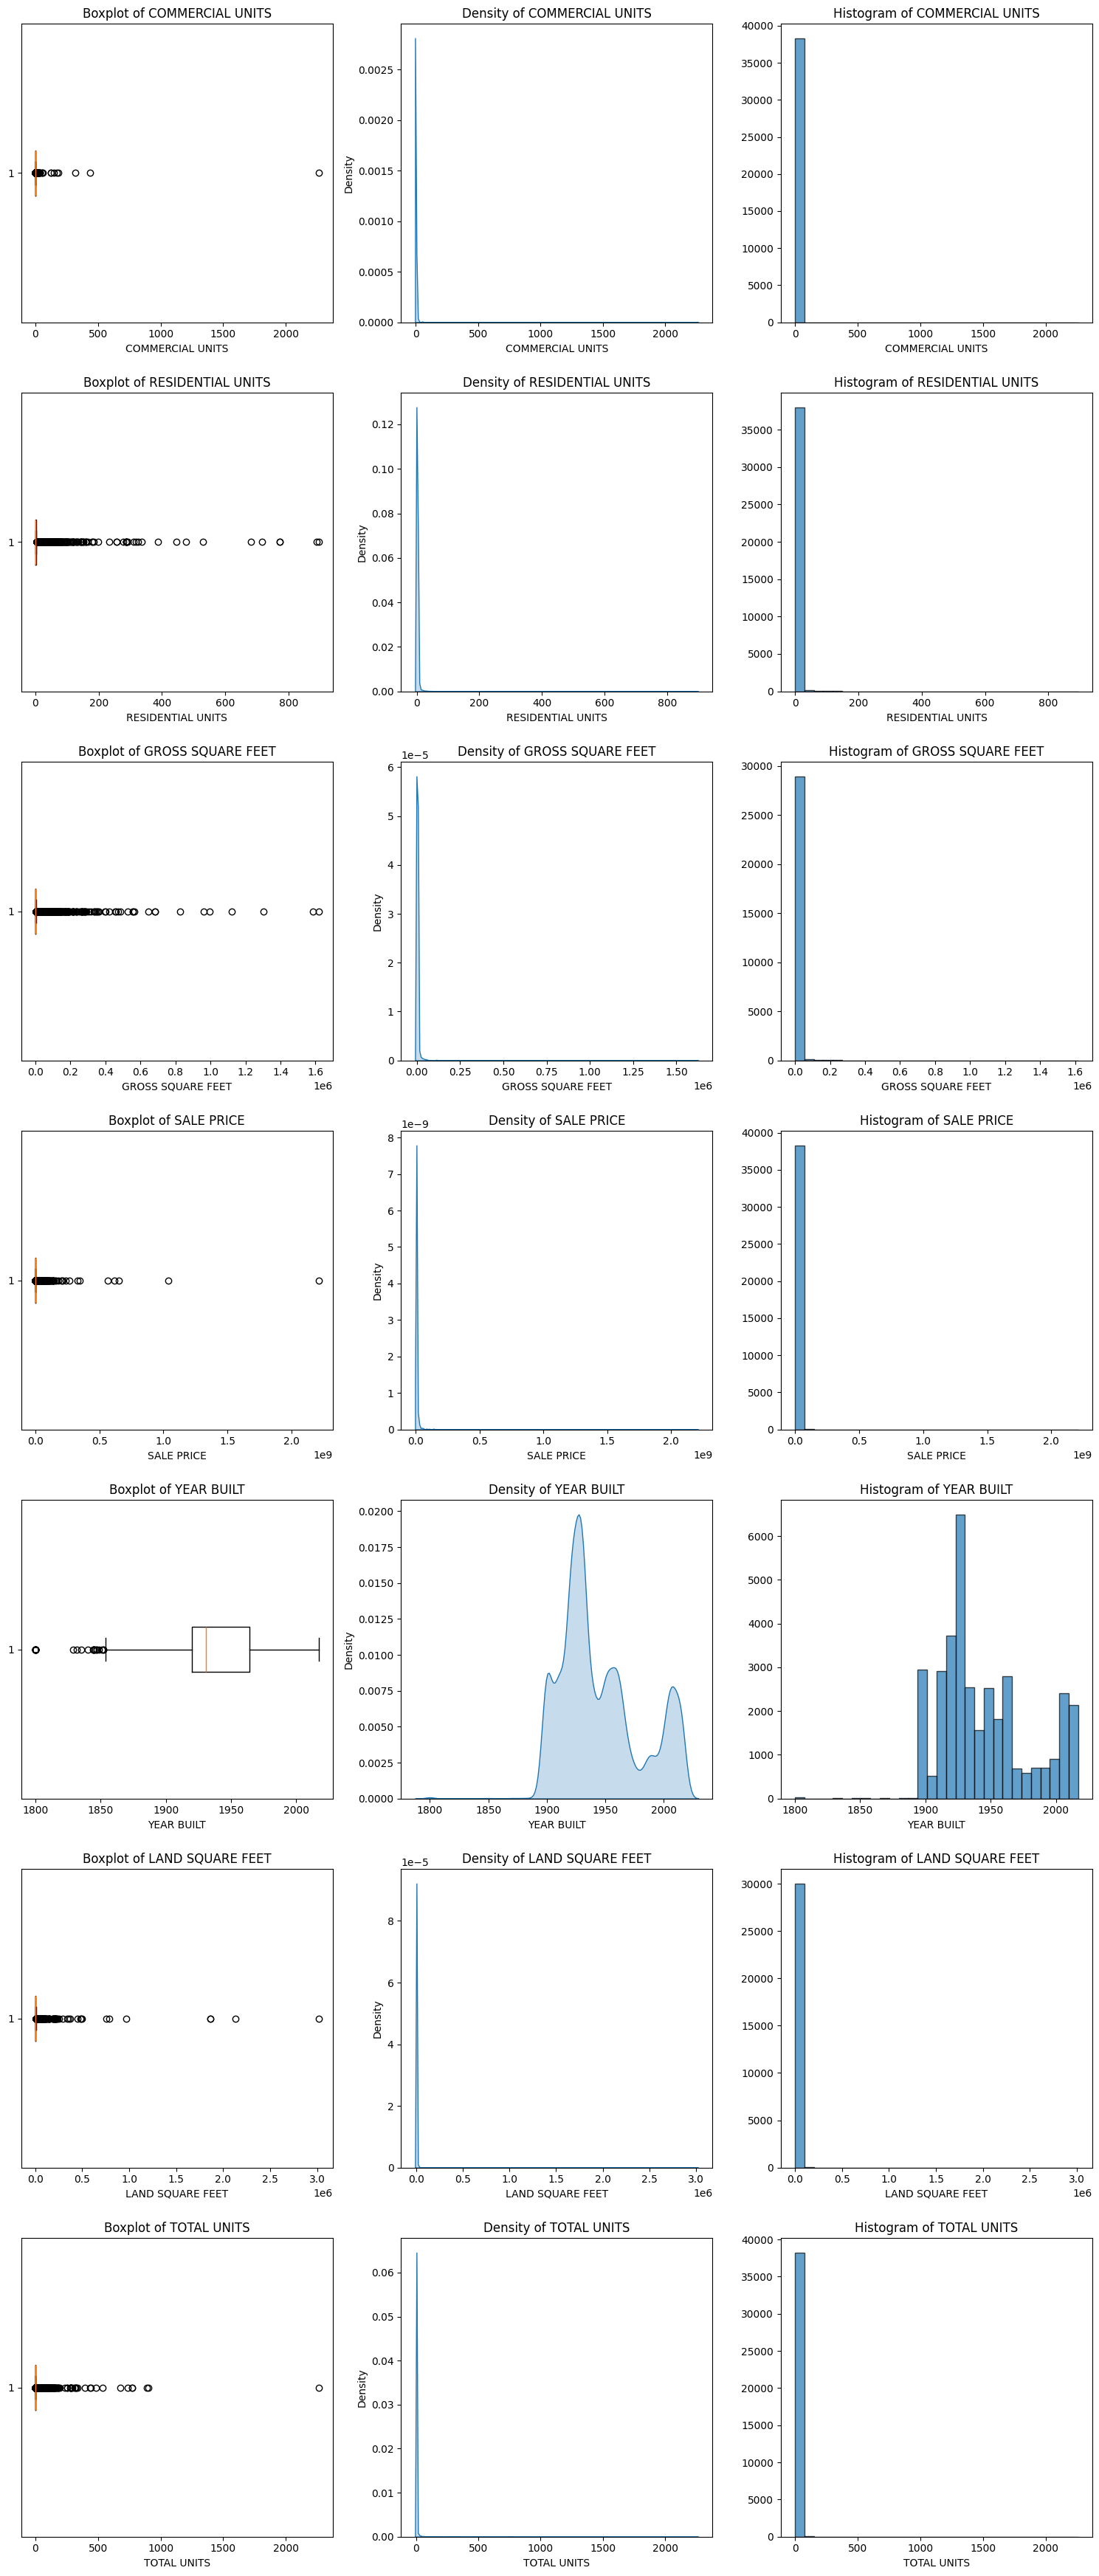

In [23]:
numeric_cols = nyc_houses_df.select_dtypes(include=["number"]).columns.tolist()

fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=3, figsize=(15, 5 * len(numeric_cols)), sharex=False, sharey=False)

for ax, col in zip(axes, numeric_cols):
    # Boxplot
    ax[0].boxplot(nyc_houses_df[col].dropna(), vert=False)
    ax[0].set_title(f"Boxplot of {col}")
    ax[0].set_xlabel(col)

    # Density Plot
    sns.kdeplot(nyc_houses_df[col].dropna(), fill=True, ax=ax[1])
    ax[1].set_title(f"Density of {col}")
    ax[1].set_xlabel(col)

    # Histogram
    ax[2].hist(nyc_houses_df[col].dropna(), bins=30, edgecolor="black", alpha=0.7)
    ax[2].set_title(f"Histogram of {col}")
    ax[2].set_xlabel(col)

plt.tight_layout()
plt.show()

***Outlier cleaning***

In [24]:
nyc_houses_df[nyc_houses_df["COMMERCIAL UNITS"] > 500]


,BUILDING CLASS AT PRESENT,COMMERCIAL UNITS,BUILDING CLASS CATEGORY,BUILDING CLASS AT TIME OF SALE,LOT,TAX CLASS AT TIME OF SALE,TAX CLASS AT PRESENT,SALE DATE,NEIGHBORHOOD,RESIDENTIAL UNITS,GROSS SQUARE FEET,BOROUGH,BLOCK,SALE PRICE,YEAR BUILT,LAND SQUARE FEET,TOTAL UNITS
448,W9,2261,33 EDUCATIONAL FACILITIES,W9,39.0,4.0,4,2016-10-26,JAMAICA,0,4522.0,4.0,9827.0,315000.0,1920,2940.0,2261


In [25]:
nyc_houses_df.loc[nyc_houses_df["COMMERCIAL UNITS"] > 500, "COMMERCIAL UNITS"] = np.nan
nyc_houses_df.loc[nyc_houses_df["TOTAL UNITS"] > 1000, "TOTAL UNITS"] = np.nan

In [26]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
GROSS SQUARE FEET,9134,23.816850,0,0.0
LAND SQUARE FEET,8276,21.579620,0,0.0
YEAR BUILT,2302,6.002451,0,0.0
BUILDING CLASS AT PRESENT,292,0.761388,0,0.0
TAX CLASS AT PRESENT,292,0.761388,0,0.0
TOTAL UNITS,1,0.002607,4877,12.716748
COMMERCIAL UNITS,1,0.002607,35218,91.830721
BUILDING CLASS AT TIME OF SALE,0,0.000000,0,0.0
BUILDING CLASS CATEGORY,0,0.000000,0,0.0
NEIGHBORHOOD,0,0.000000,0,0.0


BUILDING CLASS AT PRESENT value counts: 156


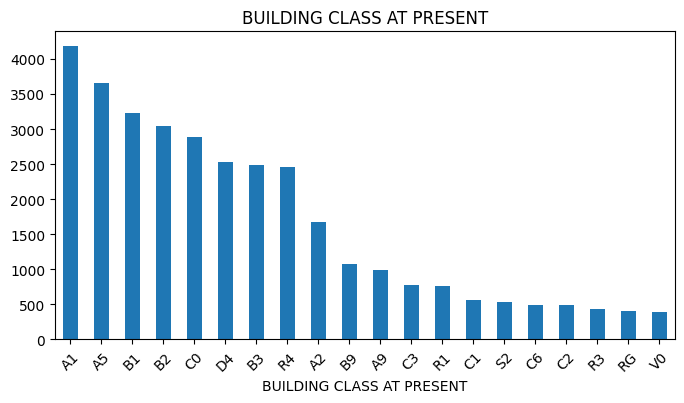

BUILDING CLASS CATEGORY value counts: 45


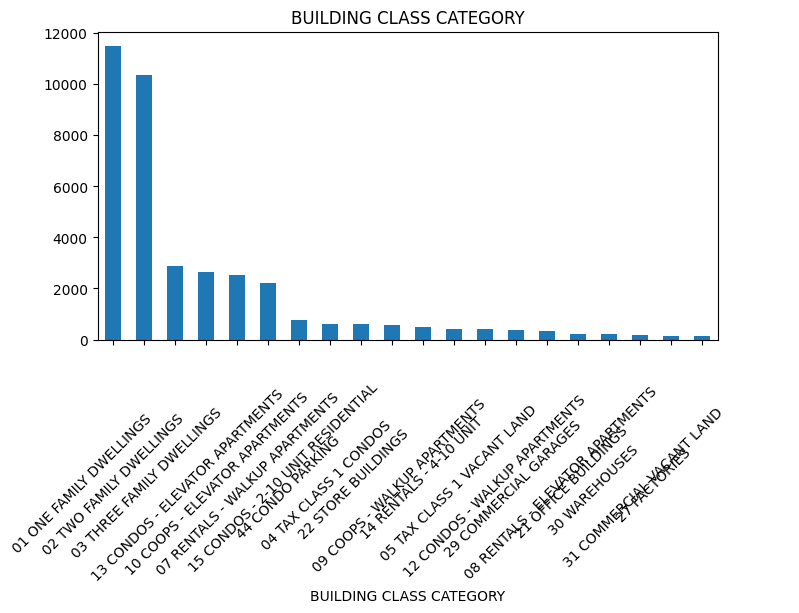

BUILDING CLASS AT TIME OF SALE value counts: 157


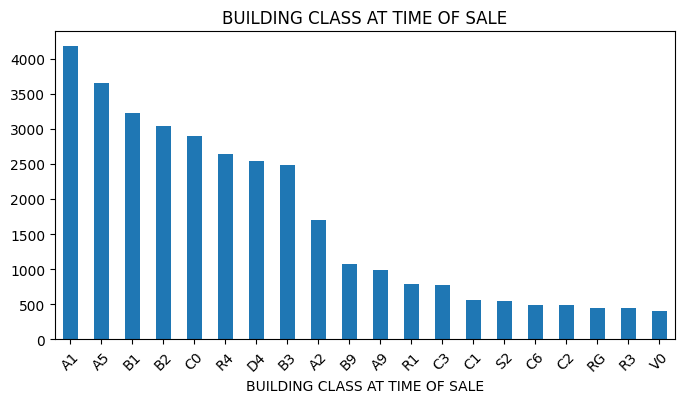

LOT value counts: 1635


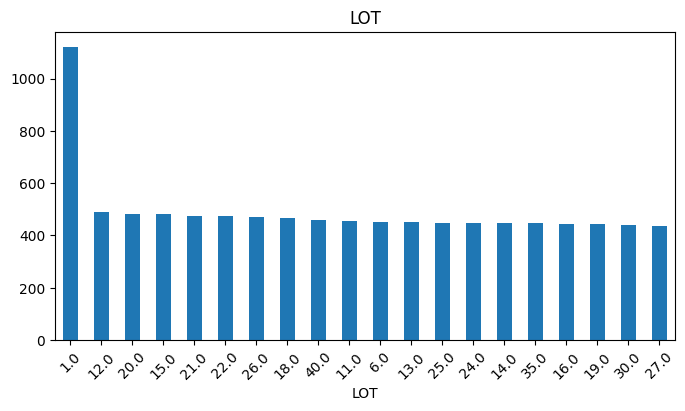

TAX CLASS AT TIME OF SALE value counts: 4


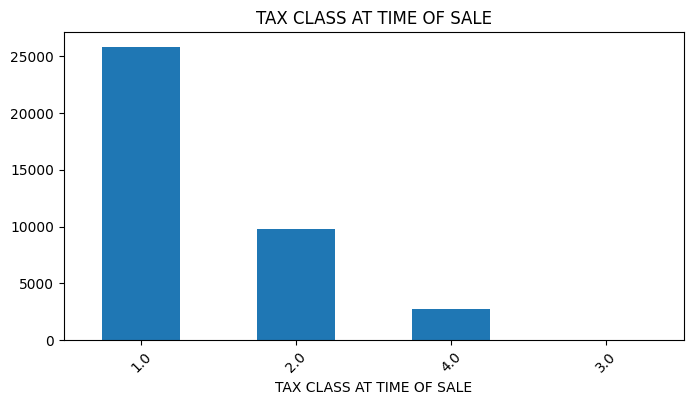

TAX CLASS AT PRESENT value counts: 10


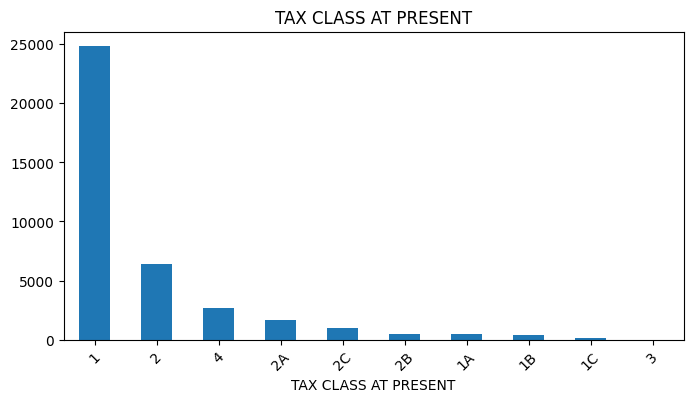

NEIGHBORHOOD value counts: 250


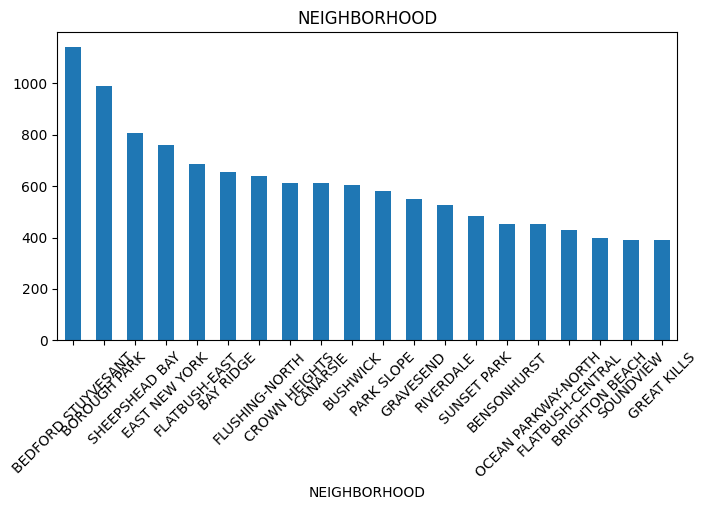

BOROUGH value counts: 5


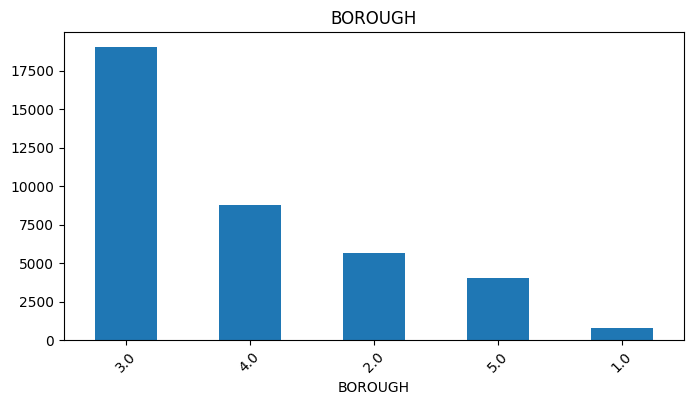

BLOCK value counts: 9967


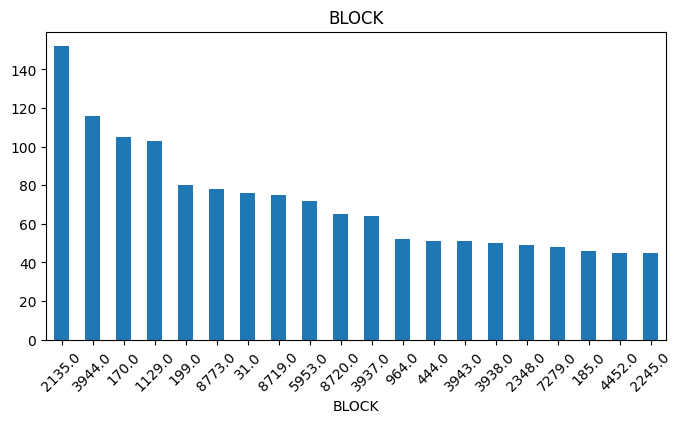

In [27]:
categorical_cols = nyc_houses_df.select_dtypes(include=["object", "category"]).columns.tolist()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    print(f"{col} value counts:", nyc_houses_df[col].nunique())
    nyc_houses_df[col].value_counts().nlargest(20).plot(
        kind="bar", title=f"{col}"
    )
    plt.xticks(rotation=45)
    plt.show()

***Missing values***

In [28]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
GROSS SQUARE FEET,9134,23.816850,0,0.0
LAND SQUARE FEET,8276,21.579620,0,0.0
YEAR BUILT,2302,6.002451,0,0.0
BUILDING CLASS AT PRESENT,292,0.761388,0,0.0
TAX CLASS AT PRESENT,292,0.761388,0,0.0
TOTAL UNITS,1,0.002607,4877,12.716748
COMMERCIAL UNITS,1,0.002607,35218,91.830721
BUILDING CLASS AT TIME OF SALE,0,0.000000,0,0.0
BUILDING CLASS CATEGORY,0,0.000000,0,0.0
NEIGHBORHOOD,0,0.000000,0,0.0


***The number of nulls less than 30%, therefore they will be imputed by mode/mean***

In [29]:
nyc_houses_df['YEAR BUILT'] = nyc_houses_df['YEAR BUILT'].astype('category')
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38351 entries, 49566 to 115930
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BUILDING CLASS AT PRESENT       38059 non-null  category      
 1   COMMERCIAL UNITS                38350 non-null  Int64         
 2   BUILDING CLASS CATEGORY         38351 non-null  category      
 3   BUILDING CLASS AT TIME OF SALE  38351 non-null  category      
 4   LOT                             38351 non-null  category      
 5   TAX CLASS AT TIME OF SALE       38351 non-null  category      
 6   TAX CLASS AT PRESENT            38059 non-null  category      
 7   SALE DATE                       38351 non-null  datetime64[ns]
 8   NEIGHBORHOOD                    38351 non-null  category      
 9   RESIDENTIAL UNITS               38351 non-null  Int64         
 10  GROSS SQUARE FEET               29217 non-null  float64       
 11  BO

In [30]:
mean_columns = ['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'COMMERCIAL UNITS']
mode_columns = ['BUILDING CLASS AT PRESENT', 'TAX CLASS AT PRESENT', 'YEAR BUILT']

for col in mean_columns:
    mean_value = nyc_houses_df[col].mean()
    if pd.api.types.is_integer_dtype(nyc_houses_df[col]):
        mean_value = int(mean_value)
    nyc_houses_df[col].fillna(mean_value, inplace=True)

for col in mode_columns:
    nyc_houses_df[col].fillna(nyc_houses_df[col].mode()[0], inplace=True)

# recalculate the total units because we have imputed some values
nyc_houses_df['TOTAL UNITS'] = nyc_houses_df['COMMERCIAL UNITS'] + nyc_houses_df['RESIDENTIAL UNITS']

C:\Users\SOULG\AppData\Local\Temp\ipykernel_11092\1804464953.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nyc_houses_df[col].fillna(mean_value, inplace=True)
C:\Users\SOULG\AppData\Local\Temp\ipykernel_11092\1804464953.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [31]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
BUILDING CLASS AT PRESENT,0,0.0,0,0.0
COMMERCIAL UNITS,0,0.0,35219,91.833329
BUILDING CLASS CATEGORY,0,0.0,0,0.0
BUILDING CLASS AT TIME OF SALE,0,0.0,0,0.0
LOT,0,0.0,0,0.0
TAX CLASS AT TIME OF SALE,0,0.0,0,0.0
TAX CLASS AT PRESENT,0,0.0,0,0.0
SALE DATE,0,0.0,0,0.0
NEIGHBORHOOD,0,0.0,0,0.0
RESIDENTIAL UNITS,0,0.0,6305,16.440249


In [32]:
duplicate_rows = nyc_houses_df.duplicated().sum()
print("Number of duplicate rows: ", duplicate_rows)

Number of duplicate rows:  35


In [33]:
nyc_houses_df = nyc_houses_df.drop_duplicates()
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38316 entries, 49566 to 115930
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BUILDING CLASS AT PRESENT       38316 non-null  category      
 1   COMMERCIAL UNITS                38316 non-null  Int64         
 2   BUILDING CLASS CATEGORY         38316 non-null  category      
 3   BUILDING CLASS AT TIME OF SALE  38316 non-null  category      
 4   LOT                             38316 non-null  category      
 5   TAX CLASS AT TIME OF SALE       38316 non-null  category      
 6   TAX CLASS AT PRESENT            38316 non-null  category      
 7   SALE DATE                       38316 non-null  datetime64[ns]
 8   NEIGHBORHOOD                    38316 non-null  category      
 9   RESIDENTIAL UNITS               38316 non-null  Int64         
 10  GROSS SQUARE FEET               38316 non-null  float64       
 11  BO

***Correlation analysis:*** to delete or not variables

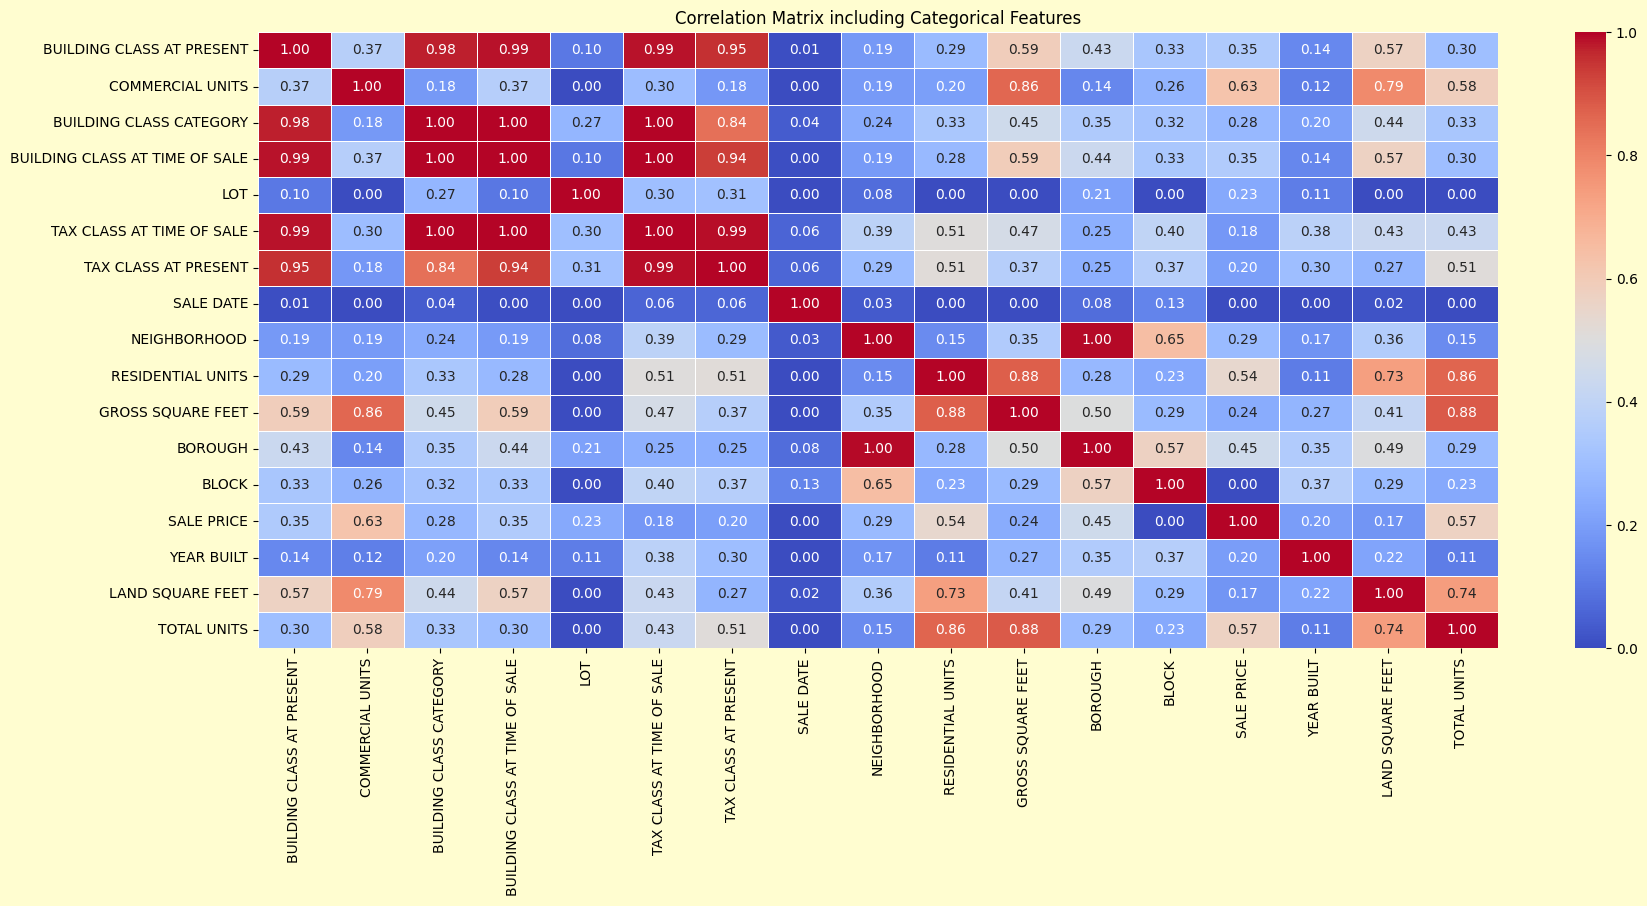

In [34]:
# Correlation matrix
associations_df = associations(nyc_houses_df, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']

# Heatmap
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')  # Set background color to cream
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()


In [35]:
# Select categorical columns
categorical_columns = nyc_houses_df.select_dtypes(include=['category', 'object']).columns

# Print the number of unique values for each categorical column
for col in categorical_columns:
    print(f"{col}: {nyc_houses_df[col].nunique()} unique values")

BUILDING CLASS AT PRESENT: 156 unique values
BUILDING CLASS CATEGORY: 45 unique values
BUILDING CLASS AT TIME OF SALE: 157 unique values
LOT: 1635 unique values
TAX CLASS AT TIME OF SALE: 4 unique values
TAX CLASS AT PRESENT: 10 unique values
NEIGHBORHOOD: 250 unique values
BOROUGH: 5 unique values
BLOCK: 9967 unique values
YEAR BUILT: 148 unique values


🏡 ***Feature Selection & Correlation Analysis***

🔍 ***High and Low Correlation Analysis***

🔴 ***High Correlations |0.8 - 1.0|***
These columns are highly correlated, making them redundant. We should **keep only one** in each case.

| Variable 1 | Variable 2 | Correlation | Decision |
|----------|----------|-------------|------------|
| **BUILDING CLASS CATEGORY** | **BUILDING CLASS AT TIME OF SALE** | 1.00 | **Drop `BUILDING CLASS CATEGORY`**, as it's redundant. |
| **BUILDING CLASS AT PRESENT** | **BUILDING CLASS AT TIME OF SALE** | 0.99 | **Drop `BUILDING CLASS AT PRESENT`**, keep `BUILDING CLASS AT TIME OF SALE` (historical info is more relevant). |
| **TAX CLASS AT PRESENT** | **TAX CLASS AT TIME OF SALE** | 0.99 | **Drop `TAX CLASS AT PRESENT`** |
|**BUILDING CLASS AT TIME OF SALE**| **TAX CLASS AT TIME OF SALE**| 1.0 | **Drop `BUILDING CLASS AT TIME OF SALE`** |
| **TOTAL UNITS** | **RESIDENTIAL UNITS & COMMERCIAL UNITS** | 0.86 | **Drop `TOTAL UNITS`**, since it can be computed. |
| **NEIGHBORHOOD** | **BOROUGH** | 1.0 | **Drop `NEIGHBORHOOD`**, as `BOROUGH` captures regional location effectively. |



🔵 ***Low Correlations |0.0 - 0.1|***
These columns have little to no relationship with `SALE PRICE`, making them **irrelevant for prediction**.

| Variable | Correlation with `SALE PRICE` | Decision |
|--------|----------------------|------------|
| **SALE DATE** | ~0.00 | **Drop it** (date of sale does not influence price). |
| **LOT** | ~0.00 - 0.10 | **Drop it** (lot number is irrelevant). |
| **BLOCK** | ~0.00 | **Drop it** (too many unique values with weak correlation). |

In [36]:
## 🚀 Final Decision: Dropped Columns
columns_to_drop = [
    "BUILDING CLASS CATEGORY",  # Redundant
    "BUILDING CLASS AT PRESENT",  # Keep "AT TIME OF SALE" instead
    "TAX CLASS AT PRESENT",  # Keep AT TIME OF SALE instead
    "BUILDING CLASS AT TIME OF SALE", # keep TAX CLASS AT TIME OF SALE instead
    "TOTAL UNITS",  # Can be computed
    "NEIGHBORHOOD",  # Redundant
    "LOT",  # Irrelevant for prediction
    "SALE DATE",  # Irrelevant for prediction
    "BLOCK"  # Too many unique values
]

# Drop columns
nyc_houses_df.drop(columns=columns_to_drop, inplace=True)


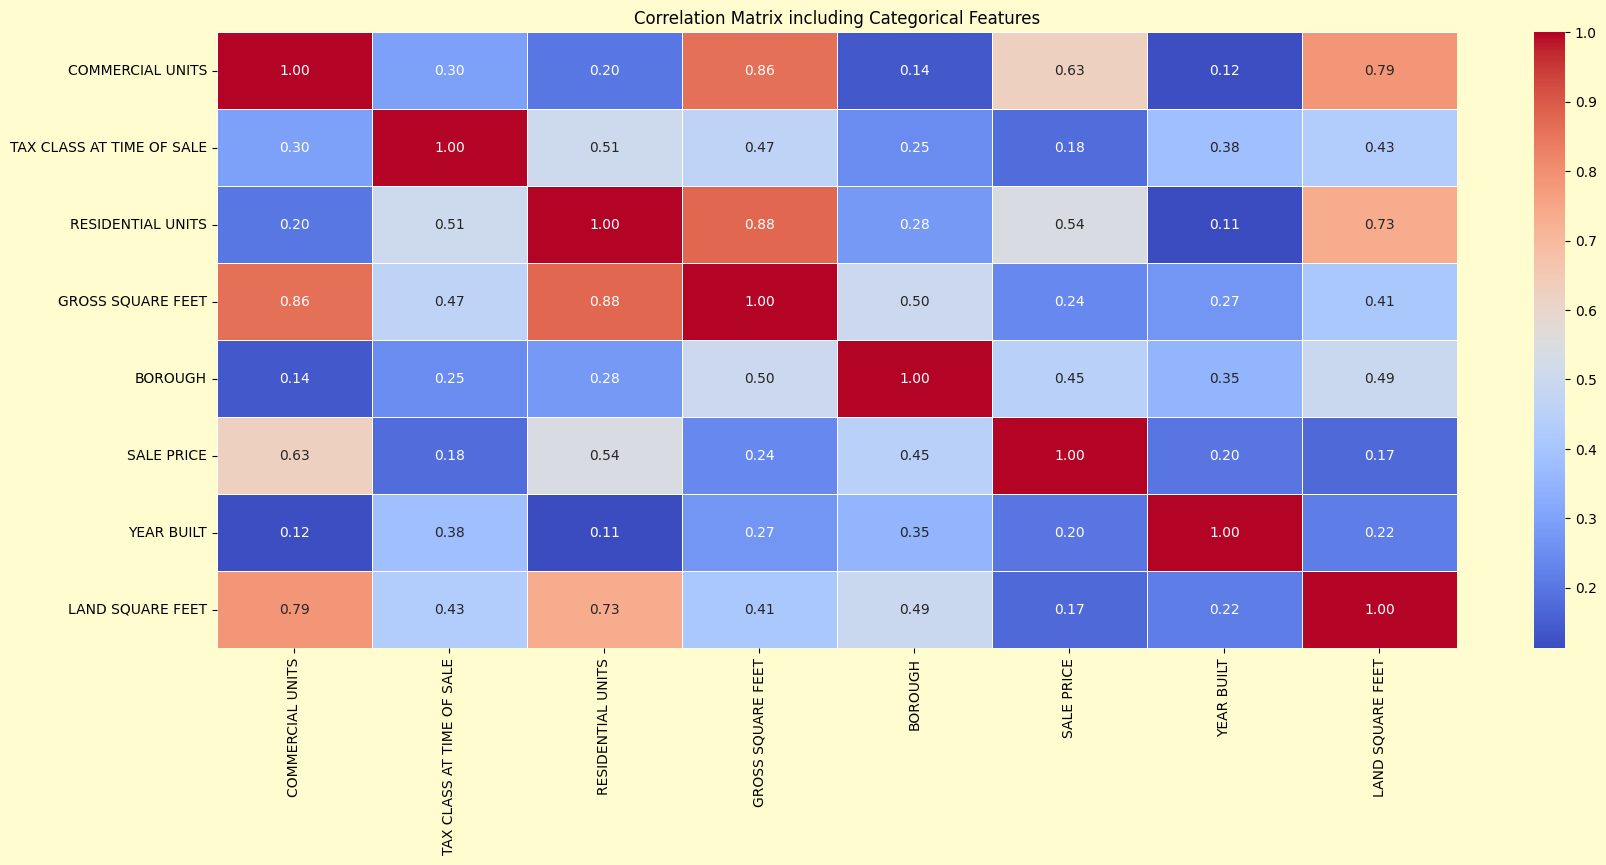

In [37]:
# Correlation matrix
associations_df = associations(nyc_houses_df, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']

# Heatmap
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0')  # Set background color to cream
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

***The idea is not to run out of variables, so no more columns will be deleted.***

In [40]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
COMMERCIAL UNITS,0,0.0,35191,91.844138
TAX CLASS AT TIME OF SALE,0,0.0,0,0.0
RESIDENTIAL UNITS,0,0.0,6283,16.397849
GROSS SQUARE FEET,0,0.0,0,0.0
BOROUGH,0,0.0,0,0.0
SALE PRICE,0,0.0,7986,20.842468
YEAR BUILT,0,0.0,0,0.0
LAND SQUARE FEET,0,0.0,0,0.0


Removing records where ***SALE PRICE = 0*** is essential because these entries do **NOT** provide useful information for model training or analysis. Keeping them in the dataset could introduce noise and affect statistical integrity.

However, instead of discarding them completely, we store these records separately for future prediction.

In [42]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"
INTERIM_DIR = DATA_DIR / "future_data"
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

# Filter records where SALE PRICE is 0
sale_price_zero_df = nyc_houses_df[nyc_houses_df["SALE PRICE"] == 0].copy()

# Drop SALE PRICE column (since we want to predict it later)
sale_price_zero_df.drop(columns=["SALE PRICE"], inplace=True)

# Save records for future prediction
sale_price_zero_df.to_csv(INTERIM_DIR / "nyc_houses_to_predict.csv", index=False)

In [43]:
# Remove those records from the original dataset
nyc_houses_df = nyc_houses_df[nyc_houses_df["SALE PRICE"] != 0]

# Save the cleaned dataset back to the raw directory (or another location if preferred)
nyc_houses_df.to_csv(DATA_DIR / "01_raw/nyc_houses_cleaned.csv", index=False)

In [45]:
missing_and_zero_values_summary(nyc_houses_df)

,Nulls,Percentage Nulls (%),Zero values,Percentage Zeros (%)
COMMERCIAL UNITS,0,0.0,28153,92.822288
TAX CLASS AT TIME OF SALE,0,0.0,0,0.0
RESIDENTIAL UNITS,0,0.0,4543,14.978569
GROSS SQUARE FEET,0,0.0,0,0.0
BOROUGH,0,0.0,0,0.0
SALE PRICE,0,0.0,0,0.0
YEAR BUILT,0,0.0,0,0.0
LAND SQUARE FEET,0,0.0,0,0.0


In [46]:
nyc_houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30330 entries, 49566 to 102588
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   COMMERCIAL UNITS           30330 non-null  Int64   
 1   TAX CLASS AT TIME OF SALE  30330 non-null  category
 2   RESIDENTIAL UNITS          30330 non-null  Int64   
 3   GROSS SQUARE FEET          30330 non-null  float64 
 4   BOROUGH                    30330 non-null  category
 5   SALE PRICE                 30330 non-null  float64 
 6   YEAR BUILT                 30330 non-null  category
 7   LAND SQUARE FEET           30330 non-null  float64 
dtypes: Int64(2), category(3), float64(3)
memory usage: 1.6 MB


### ***PipeLines***

In [ ]:
cols_numeric = ['COMMERCIAL UNITS', 'TOTAL UNITS', 'RESIDENTIAL UNITS', 'GROSS SQUARE FEET', 'SALE PRICE', 'YEAR BUILT', 'LAND SQUARE FEET']
cols_categoric = ['BUILDING CLASS AT PRESENT', 'BUILDING CLASS CATEGORY', 'BUILDING CLASS AT TIME OF SALE', 'LOT', 'ZIP CODE', 'NEIGHBORHOOD', 'BOROUGH', 'BLOCK']
cols_categoric_ord = ['TAX CLASS AT TIME OF SALE', 'TAX CLASS AT PRESENT']

In [ ]:
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

categorical_ord_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OrdinalEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipe, cols_numeric),
        ("categoric", categorical_pipe, cols_categoric),
        ("categoric ordinales", categorical_ord_pipe, cols_categoric_ord),
    ]
)


In [ ]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['COMMERCIAL UNITS', 'TOTAL UNITS',
                                  'RESIDENTIAL UNITS', 'GROSS SQUARE FEET',
                                  'SALE PRICE', 'YEAR BUILT',
                                  'LAND SQUARE FEET']),
                                ('categoric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['BUILDING CLASS AT PRESENT',
                                  'BUILDING CLASS CATEGORY',
                                  'BUILDING CLASS AT TIME OF SALE', 'LOT',
                                  'ZIP CODE', 'NEIGHBORHOOD', 'BOROUGH',
                                  'BLOCK']),
                                ('categoric ordinales',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OrdinalEncoder())]),
                                 ['TAX CLASS AT TIME OF SALE',
                                  'TAX CLASS AT PRESENT'])])

#### Example of the data preprocessing pipeline

***Train / Test split***

In [ ]:
X_features = nyc_houses_features.drop("SALE PRICE", axis="columns")
Y_target = nyc_houses_features["SALE PRICE"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)


ValueError: Input y contains NaN.